In [42]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [43]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials
# from googleapiclient.http import MediaFileUpload

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is not available


In [44]:
class CustomDataset(Dataset):
    def __init__(self, json_dirs, image_dirs, transform=None):
        self.json_dirs = json_dirs
        self.image_dirs = image_dirs
        self.transform = transform
        self.samples = []

        for json_dir, image_dir in zip(json_dirs, image_dirs):
            # Iterar sobre cada arquivo de imagem no diretório
            for filename in os.listdir(image_dir):
                if filename.endswith('.png'):
                    img_path = os.path.join(image_dir, filename)
                    # Verificar se existe um arquivo JSON correspondente
                    json_filename = filename.replace('.png', '.json')
                    json_path = os.path.join(json_dir, json_filename)
                    if os.path.exists(json_path):
                        with open(json_path, 'r') as f:
                            data = json.load(f)
                            labels = data.get('labels', [])
                            if labels:
                                label = float(labels[0]['class'])  
                                self.samples.append((img_path, label))
                            else:
                                print(f"Rótulo ausente para: {img_path}")
                    else:
                        print(f"Arquivo JSON correspondente não encontrado para: {img_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [45]:
json_dirs = [r'C:\Users\bruna\OneDrive - Universidade do Minho\images\0', 
             r'C:\Users\bruna\OneDrive - Universidade do Minho\images\2']
image_dirs = [r'C:\Users\bruna\OneDrive - Universidade do Minho\images\0\class_0',
              r'C:\Users\bruna\OneDrive - Universidade do Minho\images\2\class_2']

In [46]:
# Initialize lists to store file paths and labels
data = []

In [47]:
import pathlib
import numpy as np
data_dir = pathlib.Path("C:/Users/bruna/OneDrive - Universidade do Minho/images")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])).tolist() # created a list of class_names from the subdirector
class_names

['0', '1', '2', '3', '4', '6']

In [48]:
# Loop through each class folder
for json_dir, image_dir in zip(json_dirs, image_dirs):
    # Iterate over each image in the class folder
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        
        # Assign label based on folder name
        label = os.path.basename(image_dir)
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a DataFrame from the list
train = pd.DataFrame(data, columns=['image_path', 'label'])

In [49]:
train.head()

,image_path,label
0,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
1,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
2,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
3,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
4,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0


In [50]:
# Loop through each class folder
for json_dir, image_dir in zip(json_dirs, image_dirs):
    # Iterate over each image in the class folder
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        
        # Assign label based on folder name
        label = os.path.basename(image_dir)
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a DataFrame from the list
test = pd.DataFrame(data, columns=['image_path', 'label'])

In [51]:
test.head()

,image_path,label
0,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
1,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
2,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
3,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0
4,C:\Users\bruna\OneDrive - Universidade do Minh...,class_0


In [52]:
# Split the training data into training and validation sets
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=42, shuffle = True , stratify=train['label'])

# Display the shape of the resulting sets
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (6442, 2)
Validation set shape: (1611, 2)
Testing set shape: (16106, 2)


In [53]:
# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255 )

# Create an ImageDataGenerator for validation and test data (no data augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',  
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle=False,  
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 6442 validated image filenames belonging to 2 classes.
Found 1611 validated image filenames belonging to 2 classes.
Found 16106 validated image filenames belonging to 2 classes.


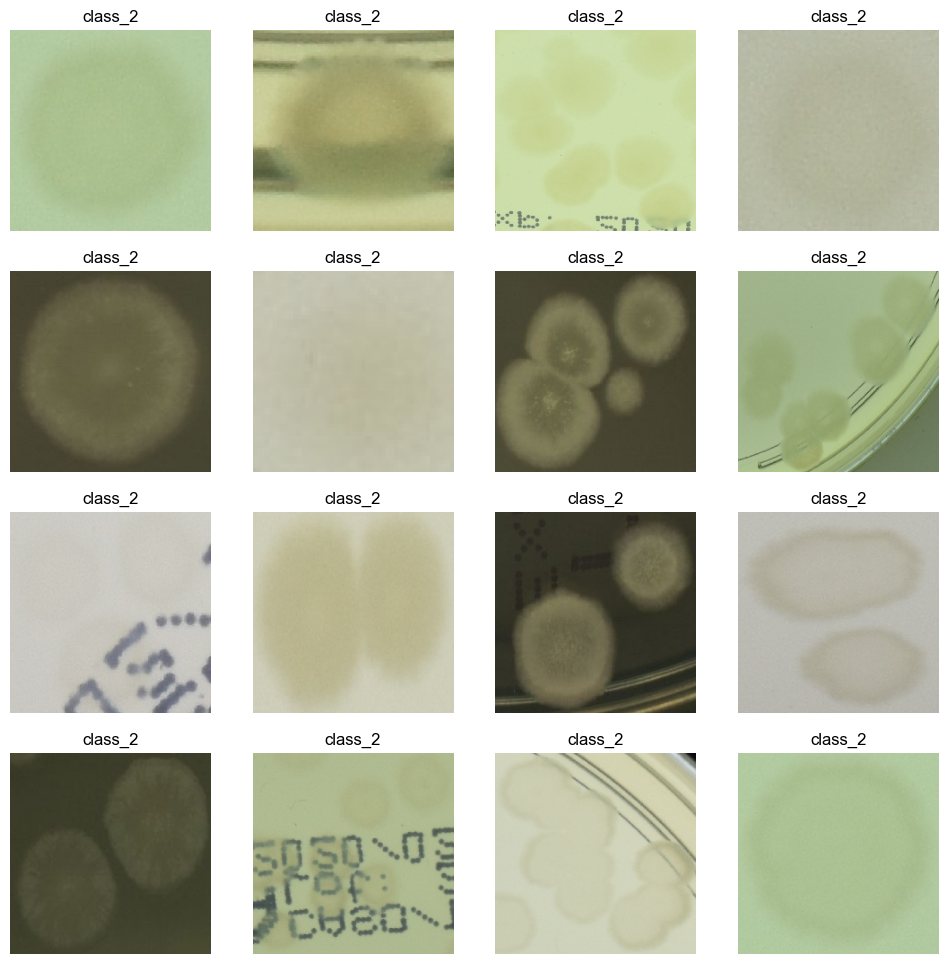

In [54]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i]) 
    label = list(train_generator.class_indices.keys())[label_index]  

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()


In [55]:
# Set the input shape based on the image size you choose
input_shape = (224, 224, 3)  # têm dimensões 224x224 pixels e têm 3 canais de cores (RGB)

# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(512, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))  # Output layer with 2 neurons for the 2 classes

# Compile the model
model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 512)     14336     
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 512)     2359808   
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 512)     2359808   
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 512)     0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 256)     1179904   
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 256)     590080    
                                                      

In [57]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('C:/Users/bruna/OneDrive - Universidade do Minho/Microbialdataset/best_model', save_best_only=True)

In [58]:
# Train the model with callbacks
history = model.fit(train_generator, epochs=10, validation_data=valid_generator,
                    validation_steps=None, shuffle=False, 
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
 20/403 [>.............................] - ETA: 37:02:41 - loss: 5.2599 - accuracy: 0.9156

KeyboardInterrupt: 

In [ ]:
train_acc = history.history['accuracy'] 
train_loss = history.history['loss'] 

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history   

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();